In [26]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from generate_image import get_images_from_shear_map, concatenate1, concatenate2, nested2normal, get_cells_from_shear_map
from utils import rotate_map_spin2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
num_sim = 1
rot_i = 0
rot_j = 0
noise_real = 0
# path_output = f'/lustre/fswork/projects/rech/prk/uid35yw/test_gss/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
path_output = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}_nside0512_rot{rot_i}{rot_j}_noisereal{noise_real}.npy'
output = np.load(path_output, allow_pickle=True).item()

In [28]:
#Checking the power spectrum of the convergence and shear fields
#Load parameters for the cosmology
h = output['cosmo_params']["h"]
Om = output['cosmo_params']["Omega_m"]
Ob = output['cosmo_params']["Omega_b"]
Oc = Om - Ob
ns = output['cosmo_params']["n_s"]
m_nu = output['cosmo_params']["m_nu"]
w = output['cosmo_params']["w"]
As = output['cosmo_params']["A_s"]

nside = output['config']['preprocessing']['nside']
lmax = 2*nside

blank_pixels = hp.UNSEEN

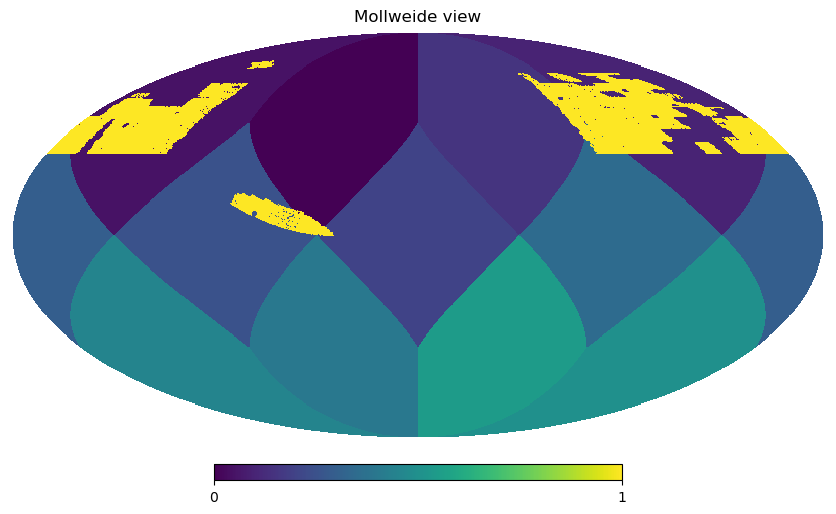

In [29]:
idx_gal = output['bin_1']['idx']

shear_map = np.zeros(hp.nside2npix(nside), dtype=np.complex128)
shear_map[idx_gal] += output['bin_1']['masked_shear_map'] + output['bin_1']['noise_map']
shear_map_sub = np.copy(shear_map)
shear_map_sub[shear_map == 0] = blank_pixels




bg = hp.vec2pix(1, *hp.pix2vec(nside, np.arange(hp.nside2npix(nside))))
gal_map = 0.05 * bg.copy()
gal_map[idx_gal] = 1 #output['bin_1']['masked_shear_map'] + output['bin_1']['noise_map']




hp.mollview(gal_map.real, cmap='viridis')
# plt.show()

## Test reordering

In [30]:
nested4 = np.array(
    [
        [0, 1, 4, 5],
        [2, 3, 6, 7],
        [8, 9, 12, 13],
        [10, 11, 14, 15]
    ]
)

nested8 = np.array(
    [
        [0, 1, 4, 5, 16, 17, 20, 21],
        [2, 3, 6, 7, 18, 19, 22, 23],
        [8, 9, 12, 13, 24, 25, 28, 29],
        [10, 11, 14, 15, 26, 27, 30, 31],
        [32, 33, 36, 37, 48, 49, 52, 53],
        [34, 35, 38, 39, 50, 51, 54, 55],
        [40, 41, 44, 45, 56, 57, 60, 61],
        [42, 43, 46, 47, 58, 59, 62, 63]
    ]
)

nested16 = np.array(
    [
        [  0,   1,   4,   5,  16,  17,  20,  21,  64,  65,  68,  69,  80, 81,  84,  85],
        [  2,   3,   6,   7,  18,  19,  22,  23,  66,  67,  70,  71,  82, 83,  86,  87],
        [  8,   9,  12,  13,  24,  25,  28,  29,  72,  73,  76,  77,  88, 89,  92,  93],
        [ 10,  11,  14,  15,  26,  27,  30,  31,  74,  75,  78,  79,  90, 91,  94,  95],
        [ 32,  33,  36,  37,  48,  49,  52,  53,  96,  97, 100, 101, 112, 113, 116, 117],
        [ 34,  35,  38,  39,  50,  51,  54,  55,  98,  99, 102, 103, 114, 115, 118, 119],
        [ 40,  41,  44,  45,  56,  57,  60,  61, 104, 105, 108, 109, 120, 121, 124, 125],
        [ 42,  43,  46,  47,  58,  59,  62,  63, 106, 107, 110, 111, 122, 123, 126, 127],
        [128, 129, 132, 133, 144, 145, 148, 149, 192, 193, 196, 197, 208, 209, 212, 213],
        [130, 131, 134, 135, 146, 147, 150, 151, 194, 195, 198, 199, 210, 211, 214, 215],
        [136, 137, 140, 141, 152, 153, 156, 157, 200, 201, 204, 205, 216, 217, 220, 221],
        [138, 139, 142, 143, 154, 155, 158, 159, 202, 203, 206, 207, 218, 219, 222, 223],
        [160, 161, 164, 165, 176, 177, 180, 181, 224, 225, 228, 229, 240, 241, 244, 245],
        [162, 163, 166, 167, 178, 179, 182, 183, 226, 227, 230, 231, 242, 243, 246, 247],
        [168, 169, 172, 173, 184, 185, 188, 189, 232, 233, 236, 237, 248, 249, 252, 253],
        [170, 171, 174, 175, 186, 187, 190, 191, 234, 235, 238, 239, 250, 251, 254, 255]
    ]
)


# nested2normal(nested4, 4), nested2normal(nested8, 8), nested2normal(nested16, 16)


## Rotation of the shear map

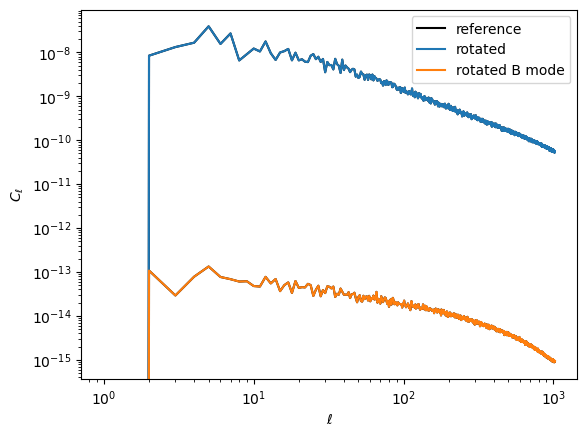

In [31]:
shear_map = output['bin_1']['gamma_weighted']

shear_map_rotated = rotate_map_spin2(shear_map, rot_i, rot_j, nside=nside)

cls = hp.anafast(np.array([shear_map.real, shear_map.real, shear_map.imag]), pol=True, lmax=lmax, use_pixel_weights=True)
cls_rotated = hp.anafast(np.array([shear_map_rotated.real, shear_map_rotated.real, shear_map_rotated.imag]), pol=True, lmax=lmax, use_pixel_weights=True)



plt.figure()

# get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, cls[1], label="reference", c='k')
plt.plot(l, cls[2], c='k')

plt.plot(l, cls_rotated[1], label="rotated")
plt.plot(l, cls_rotated[2], label="rotated B mode")

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.show()

## Generate image

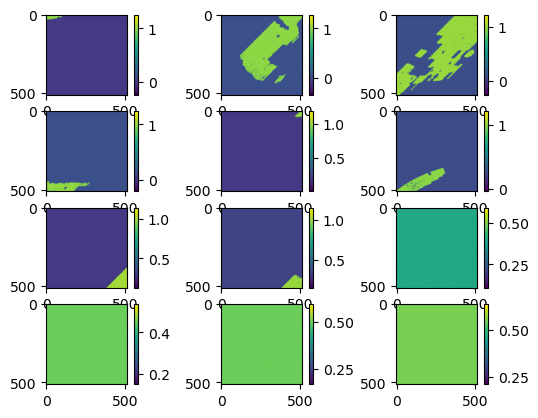

In [32]:
im = get_cells_from_shear_map(nside, gal_map, map_ordering='RING', rot_i=rot_i, rot_j=rot_j).real
for i in range(12):
    subplot = plt.subplot(4, 3, i+1)

    plt.imshow(im[i].reshape((nside, nside)), cmap='viridis')
    plt.colorbar()
plt.show()

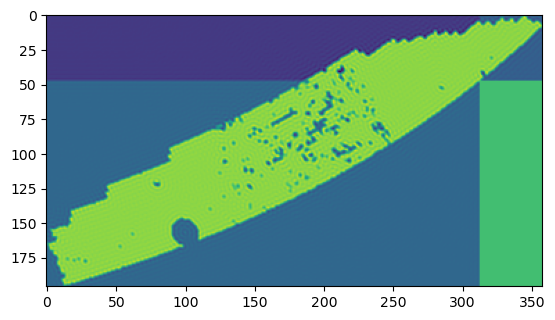

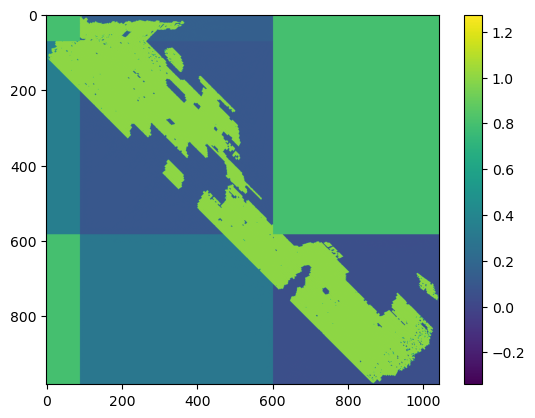

In [42]:
plt.imshow(concatenate2(nside, im, .8), cmap='viridis')
plt.show()
plt.imshow(concatenate1(nside, im, .8), cmap='viridis')
plt.colorbar()
plt.show()

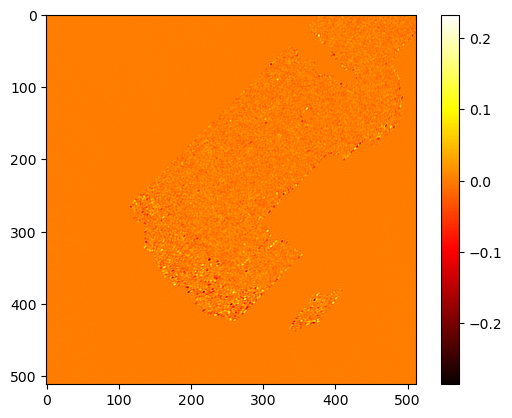

In [34]:
im1 = get_cells_from_shear_map(nside, shear_map_sub.real, map_ordering='RING', rot_i=rot_i, rot_j=rot_j)[1]

plt.imshow(im1.reshape((nside, nside)).real, cmap='hot')
plt.colorbar()


## Impact of pixelization

In [35]:
path_output0 = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}_nside0512_rot00_noisereal{noise_real}.npy'
output0 = np.load(path_output0, allow_pickle=True).item()
idx_gal0 = output0['bin_1']['idx']
del output0


In [36]:
idx_gal = output['bin_1']['idx']

shear_map = output['bin_1']['gamma_weighted']

# Rotated mask
mask1 = np.zeros(hp.nside2npix(nside), dtype=bool)
mask1[idx_gal] = True

# Orginal mask
mask0 = np.zeros(hp.nside2npix(nside), dtype=bool)
mask0[idx_gal0] = True

# Apply rotation first then the mask
masked_shear0 = shear_map.copy()
masked_shear0 = rotate_map_spin2(masked_shear0, rot_i, rot_j, inverse=True)
masked_shear0[~mask0] = blank_pixels

# Apply mask first then the rotation
masked_shear1 = shear_map.copy()
masked_shear1[~mask1] = blank_pixels
masked_shear1 = rotate_map_spin2(masked_shear1, rot_i, rot_j, inverse=True)



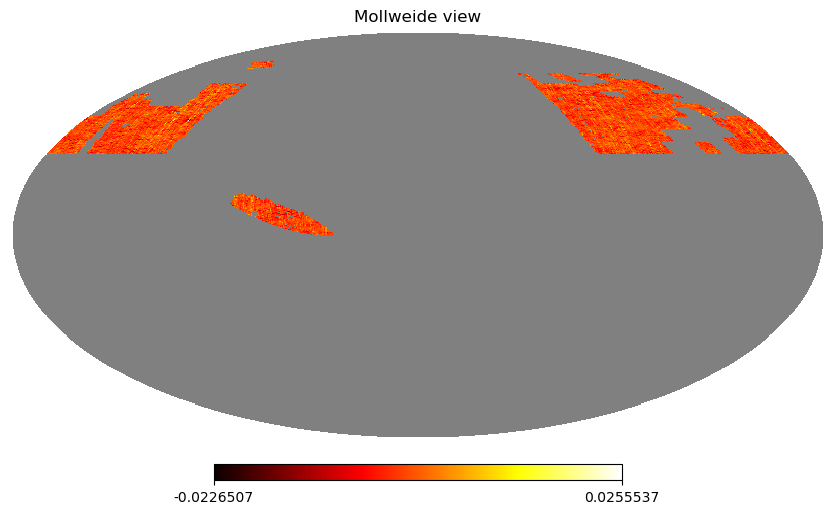

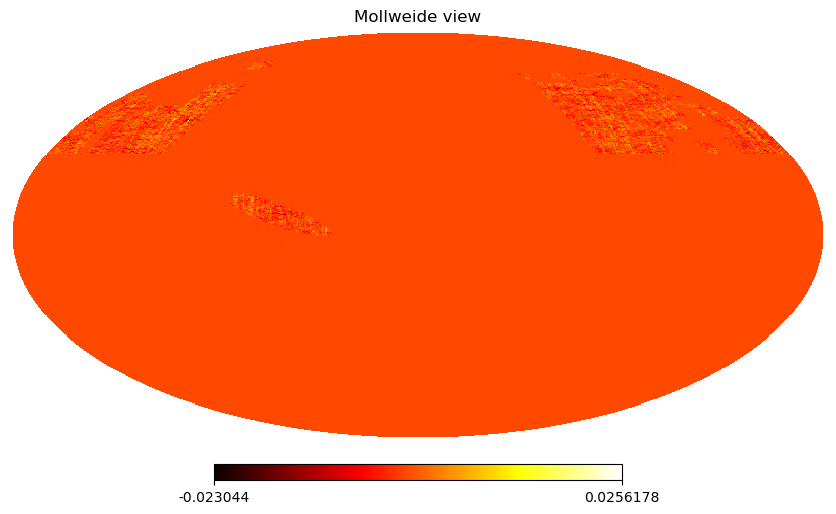

In [37]:
hp.mollview(masked_shear0.real, cmap='hot')
hp.mollview(masked_shear1.real, cmap='hot')

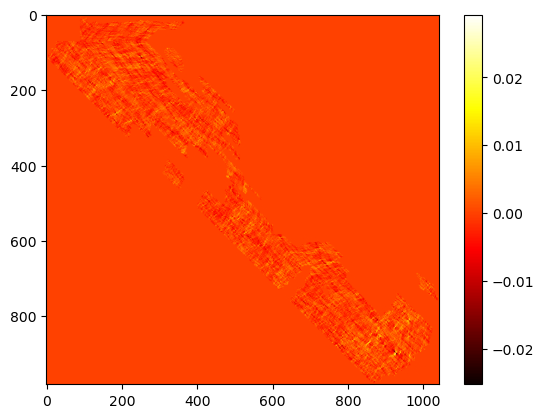

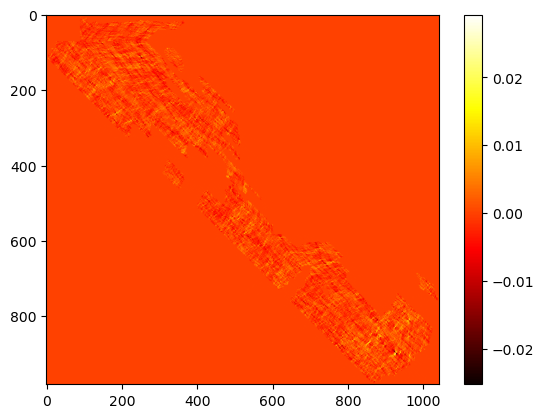

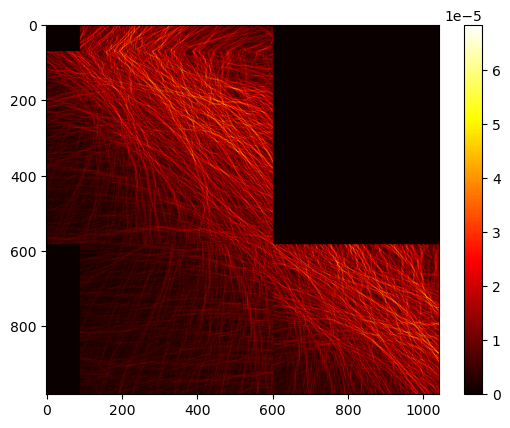

In [ ]:
im0 = get_images_from_shear_map(nside, masked_shear0.real, blank_pixels=0)[0]
im1 = get_images_from_shear_map(nside, masked_shear1.real, blank_pixels=0)[0]

plt.imshow(im0.real, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(im1.real, cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(np.abs(im1-im0), cmap='hot')
plt.colorbar()
plt.show()

In [39]:
np.abs(im0-im1).max()/np.abs(im0[im0!=blank_pixels]).mean()

0.11561179272439202